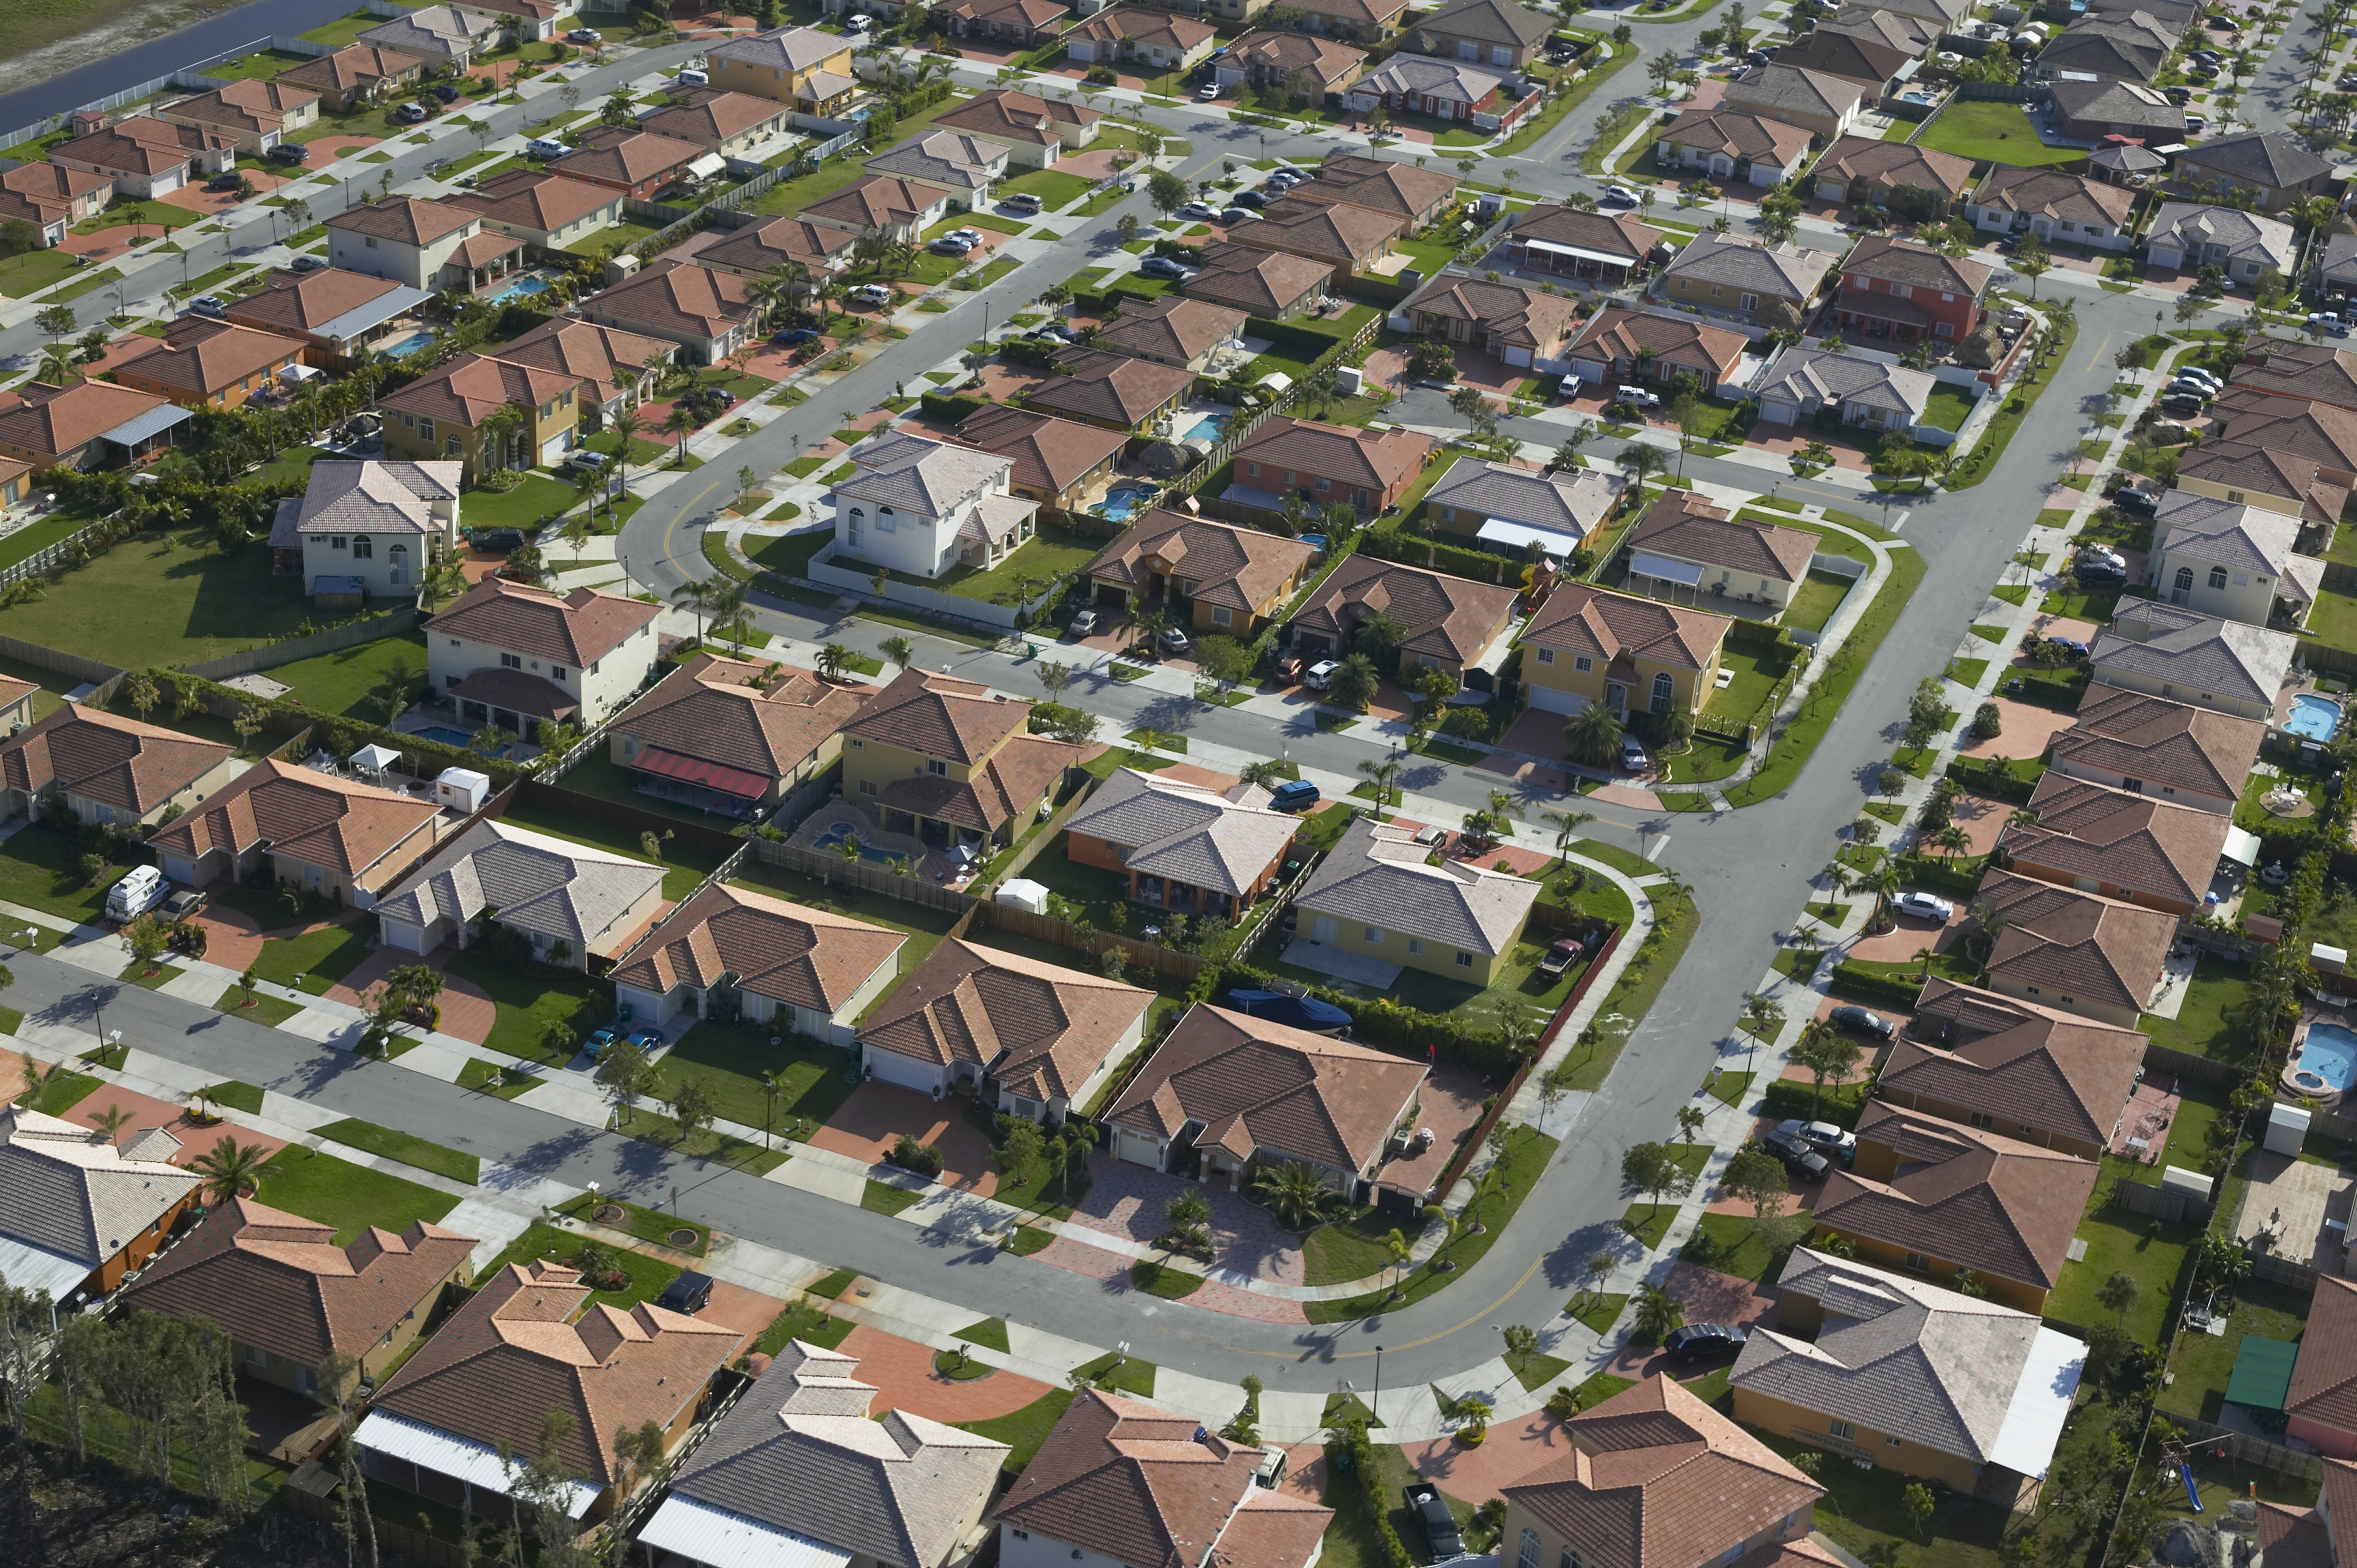



1. Aim of the project:
This project predicts the prices of houses located in the cities of the US, with the help of essential features.

2. Dataset: The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/shree1992/housedata

3.  Goal: The goal of this project is to make a prediction model which will predict the prices of the Airbnb hotels using different parameters.






**Exploratory Data Analysis (EDA)**

This is where our data visualisation journey often begins. The purpose of EDA in machine learning is to explore the quality of our data. A question to keep in mind is; are there any strange patterns that leave us scratching our heads?

In [1]:
# here are the modules we'll be using throughout this notebook
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import pandas as pd
import numpy as np
import matplotlib
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load our data from the csv file
houses = pd.read_csv('/content/data.csv') 

In [3]:
houses.describe()

price     bedrooms  ...     yr_built  yr_renovated
count  4.600000e+03  4600.000000  ...  4600.000000   4600.000000
mean   5.519630e+05     3.400870  ...  1970.786304    808.608261
std    5.638347e+05     0.908848  ...    29.731848    979.414536
min    0.000000e+00     0.000000  ...  1900.000000      0.000000
25%    3.228750e+05     3.000000  ...  1951.000000      0.000000
50%    4.609435e+05     3.000000  ...  1976.000000      0.000000
75%    6.549625e+05     4.000000  ...  1997.000000   1999.000000
max    2.659000e+07     9.000000  ...  2014.000000   2014.000000

[8 rows x 13 columns]

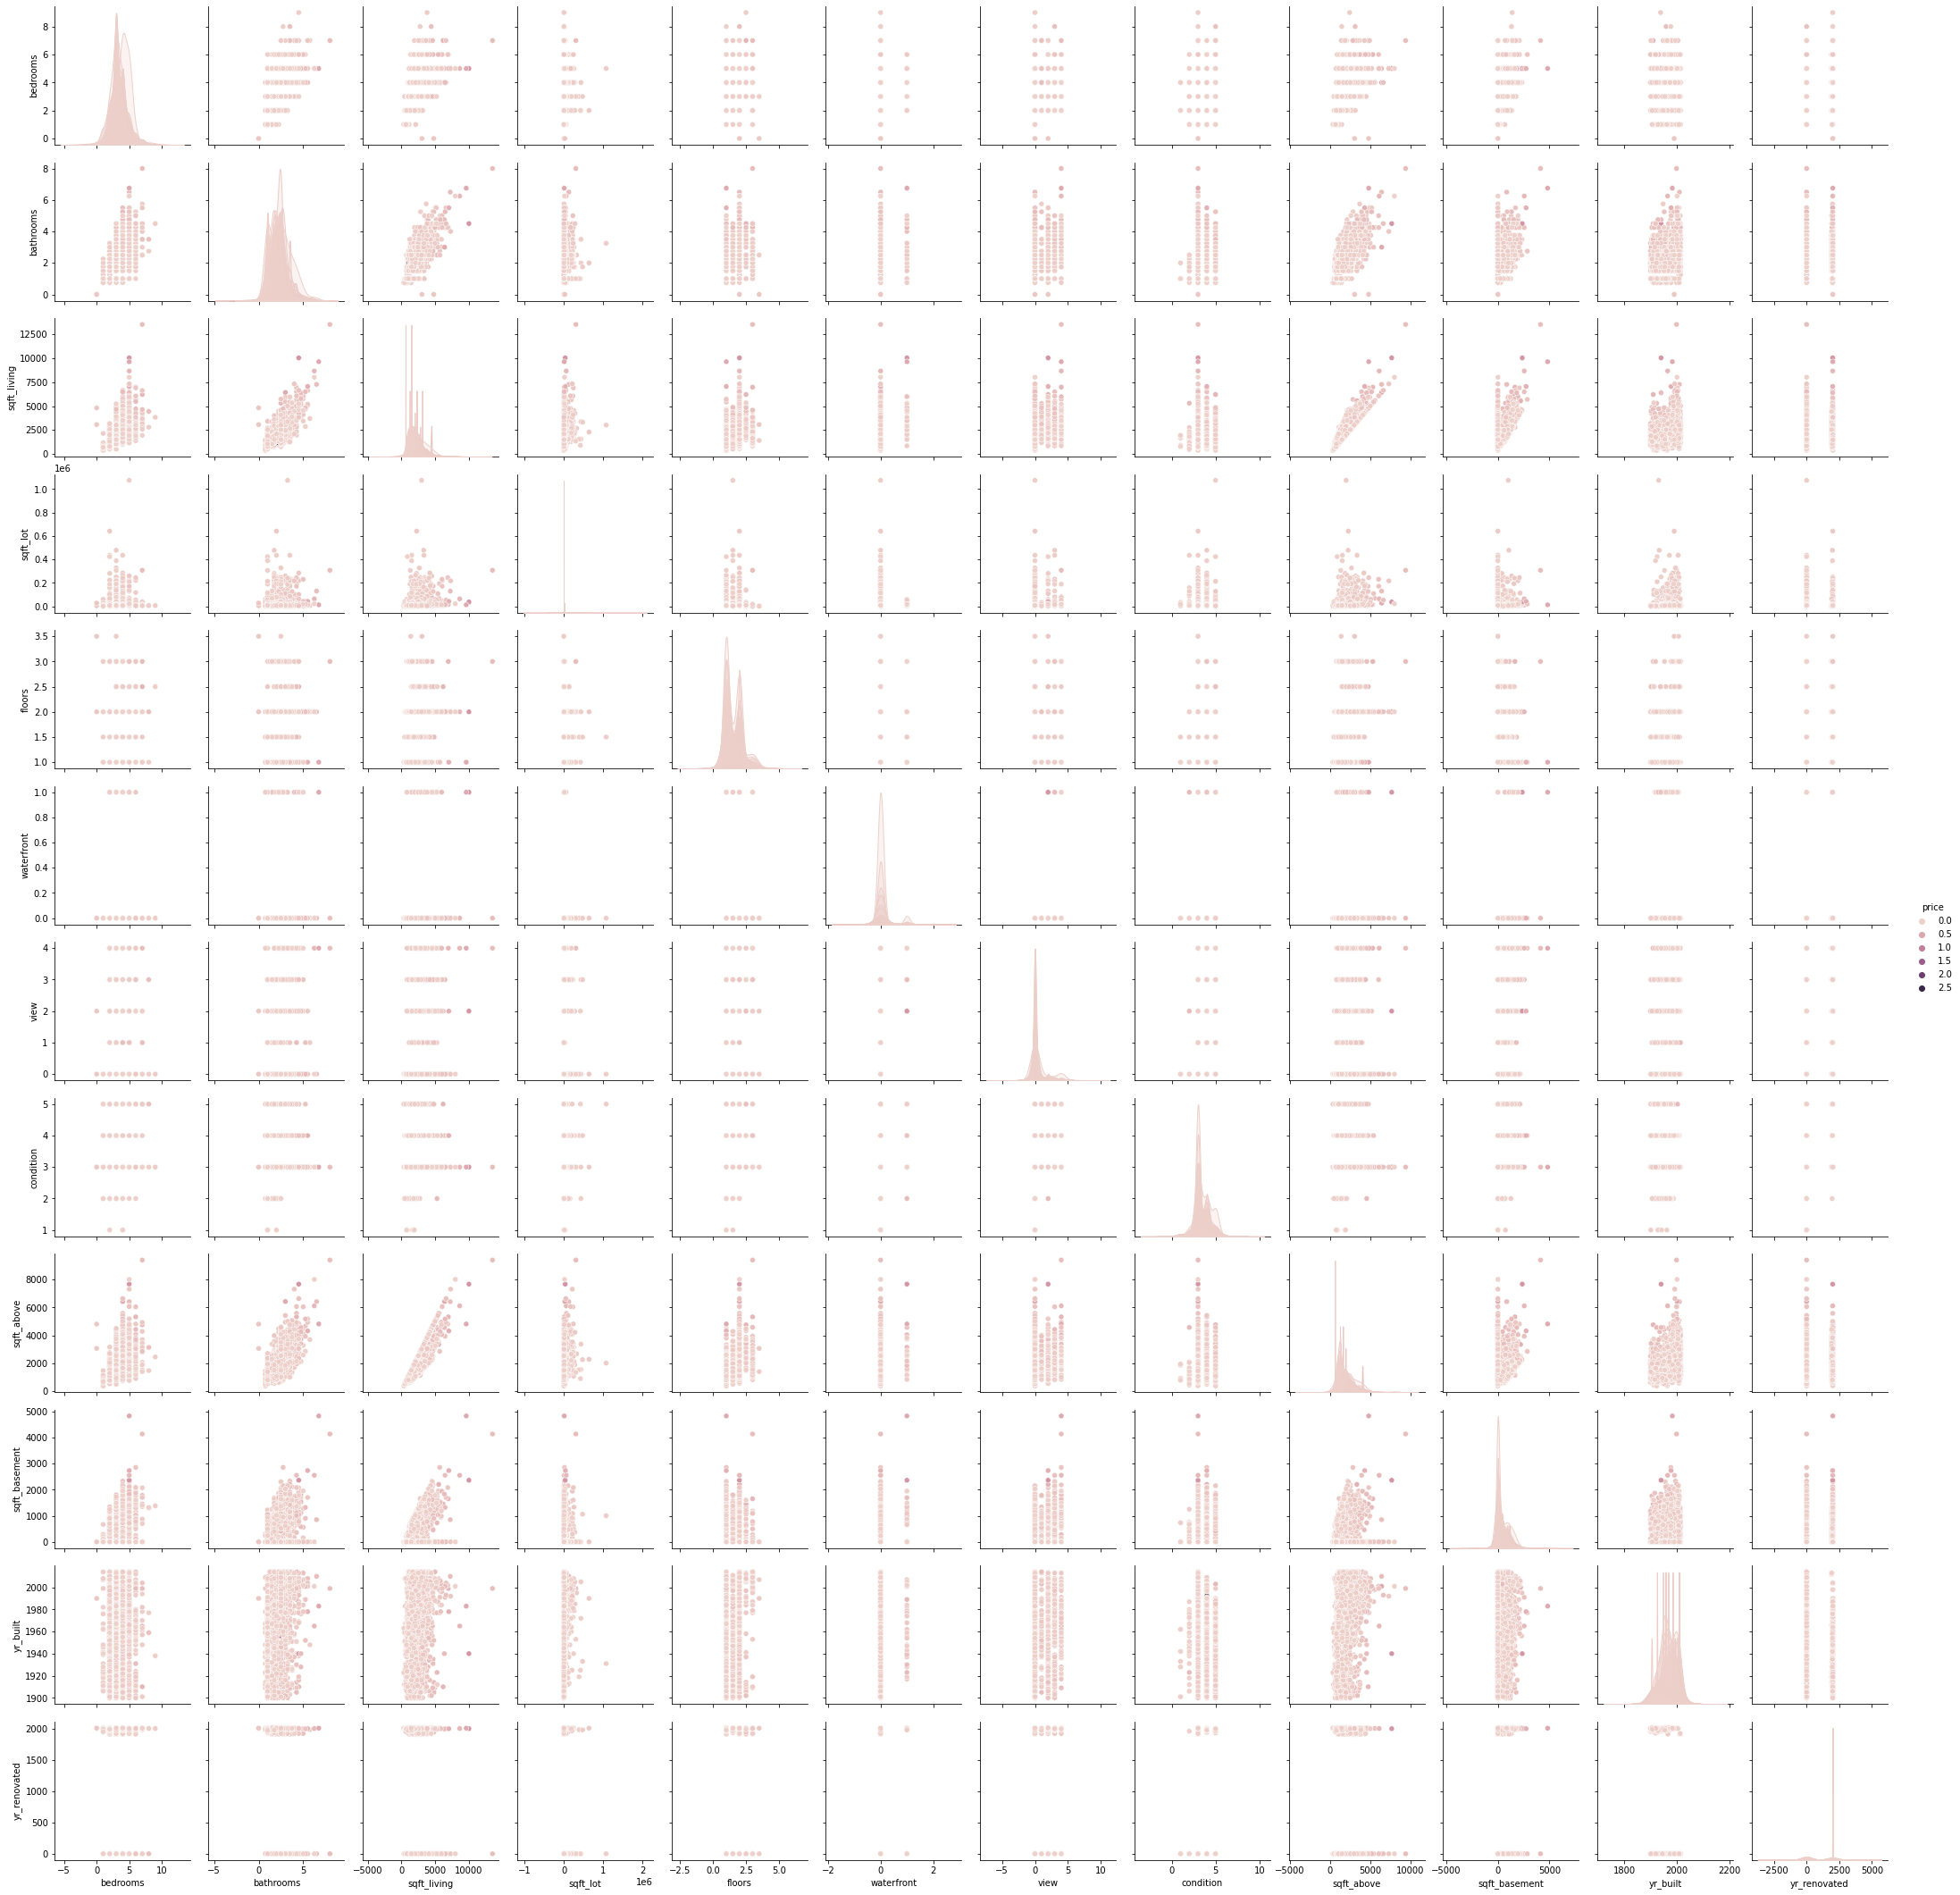

In [4]:
sns.pairplot(houses,hue='price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f97aff4d0>,
      dtype=object)

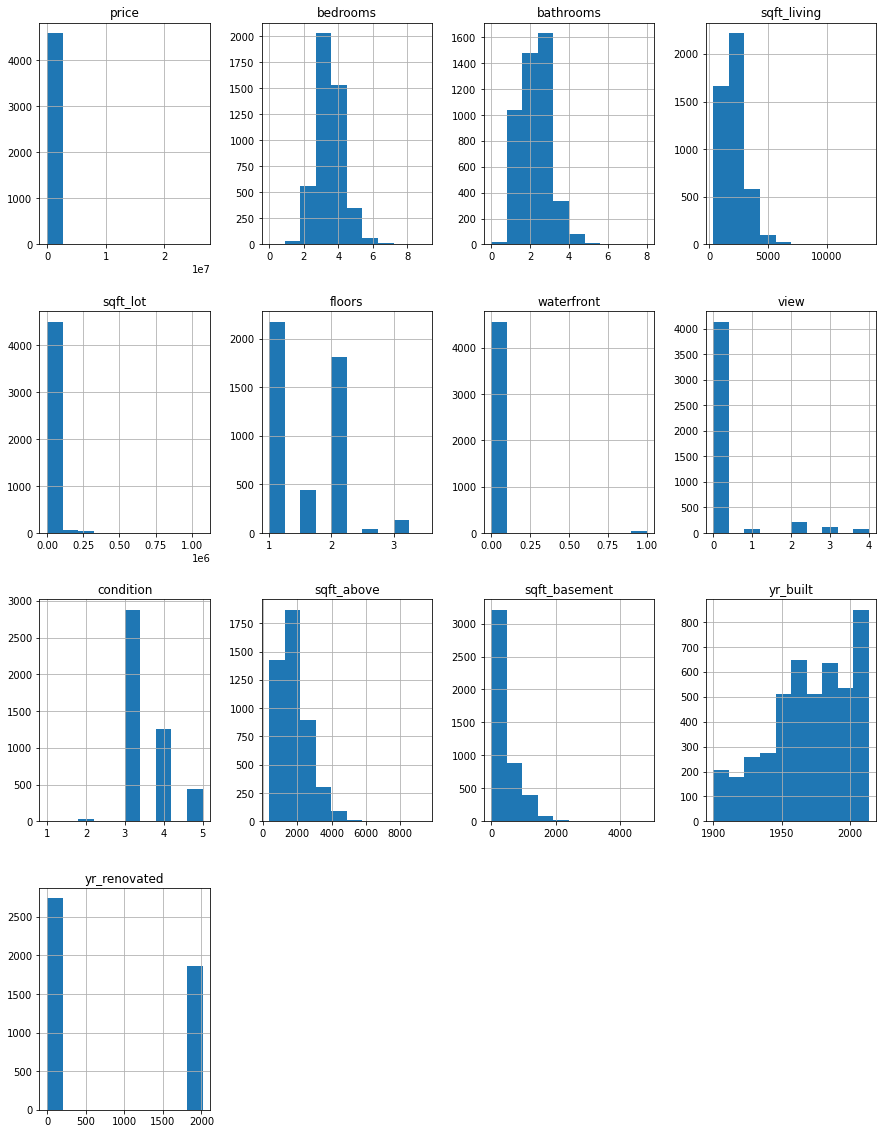

In [5]:
houses.hist(figsize=(15,20), )

In [6]:
#So, how many houses do we have in our dataset?
houses.shape

(4600, 18)

In [7]:
#We have 4600 houses in the dataset and 18 features, including price. 
#Therefore, we can choose between 17 different features that influence the price of a house. Let's check these out.
houses.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

In [8]:
#We have a nice list of all the features, some being categorical variables (object types),
#like the country of the house and some being measures (float64 or int64 types) like the surface of the basement.
#Just curious, what country are these houses in?

houses.country.value_counts()

USA    4600
Name: country, dtype: int64

In [9]:
#Let's check out the average price of a house in that area.

"The average price of a house is ${:,.0f}".format(houses.price.mean())

'The average price of a house is $551,963'

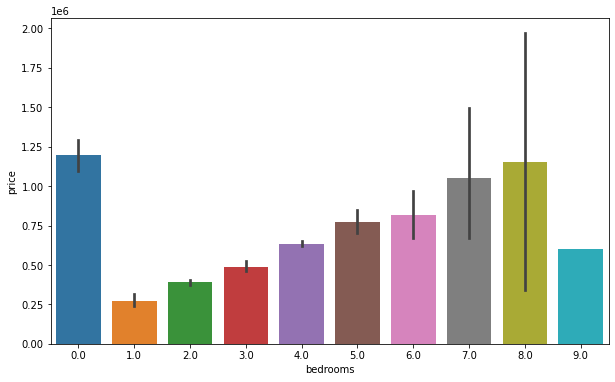

In [10]:
#get the average price for houses along their number of bedrooms:
plt.figure(figsize=(10,6))
sns.barplot(x=houses.bedrooms, y=houses['price'])

Insights we got till now: OK, something is strange here. There is clearly a relationship between the number of bedrooms and the average price of a house. However, seems that a house with 9 bedrooms sells for less than a house with 4 bedrooms...

Also, some houses don't have any rooms?

In [11]:
# get a price breakdown for each bedroom group
bybedroom = houses.groupby(['bedrooms']).price.agg([len, min, max])
#problem #1 and #2 - 2 houses with 0 bedrooms, giant outlier at 3 bedrooms
bybedroom

len        min         max
bedrooms                               
0.0          2.0  1095000.0   1295648.0
1.0         38.0        0.0    540000.0
2.0        566.0        0.0   1695000.0
3.0       2032.0        0.0  26590000.0
4.0       1531.0        0.0   4489000.0
5.0        353.0        0.0   7062500.0
6.0         61.0        0.0   3100000.0
7.0         14.0   280000.0   3200000.0
8.0          2.0   340000.0   1970000.0
9.0          1.0   599999.0    599999.0

The table above provides an explanation for the price discrepancy we have seen. There is only one house with 9 bedrooms! This may be a house located far from the city, or the owner might have needed to sell it in a hurry. Whatever the circumstances, 1 house is not big enough a sample. We'll need to do something if we want to use the number of bedrooms as a predictor in our model.

The table above also highlighted 2 other problems with the data.

1. Two houses have no bedroom!
2. Some houses have a price of zero

In [12]:
# problem #3 - houses with null prices
houses_zero= houses[houses.price==0]
print('There are '+str(len(houses_zero))+' houses without a price')

There are 49 houses without a price


Out of 4600 houses in the sample, 49 don't have a price. It's not a lot, but this might confuse the model.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


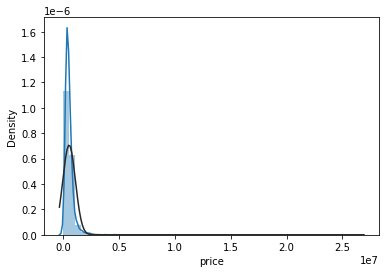

In [13]:
# problem #4 - house prices are not normal
sns.distplot(houses['price'], fit=norm)

So, to recap, we have 3 problems :

1. Houses with 0 bedroom
2. Giant outlier at almost $27M - 50 times the price of a normal house
3. 49 houses without a price

We'll take the easy way out - remove them from our analysis.

In [14]:
# new dataframe without problem #1 #2 #3
houses_o = houses[(houses.price<2.5*10**7) & (houses.bedrooms>0) & (houses.price>0)].copy()

In [15]:
#Now, there is one other potential problem with our data. There are too few houses with more than 6 bedrooms. 
#This is a problem if we want to use the number of bedrooms as a predictor of house price.
#To fix this, we can simply group the houses with 7, 8 and 9 bedrooms with the houses featuring 6 bedrooms.
#recode houses with more than 6 bedrooms as 6 bedrooms
houses_o['bedrooms_recoded'] = houses_o['bedrooms'].replace([7,8,9],6)
houses_o['renovated_0_1'] = houses_o['yr_renovated']/houses_o['yr_renovated']
houses_o['renovated_0_1'] = houses_o['renovated_0_1'].fillna(0)

Correlations: 

It’s often good to plot a correlation matrix to give you an idea of relationships that exist in your data. It can also guide your model building. For example, if you see a lot of your features are correlated with each other you might want to avoid linear regression.

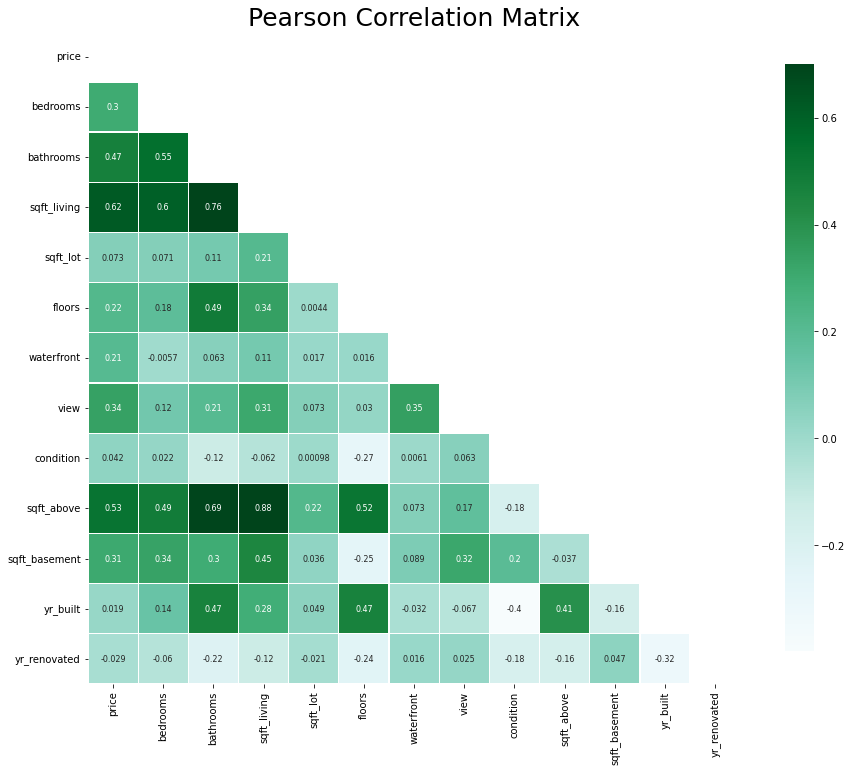

In [16]:
features = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated']
mask = np.zeros_like(houses_o[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(houses_o[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

The correlation measure used here is Pearson’s correlation. In our case the lighter the square the stronger the correlation between two variables.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


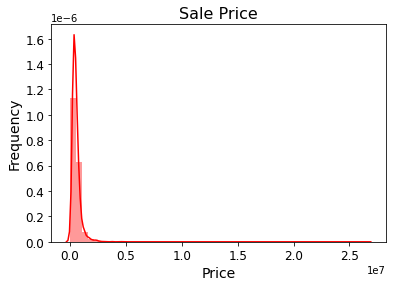

In [17]:
# Distribution plot for some more visualization

sns.distplot(houses['price'], color = 'r')
plt.title('Sale Price', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('distplot.png')
plt.show()

**Exploring Models**: 

In [18]:
#importing necessary stuff
from sklearn.model_selection import train_test_split # data split
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from termcolor import colored as cl # text customization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


In [19]:
houses.dropna(inplace = True)
print(cl(houses.isnull().sum(), attrs = ['bold']))

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64


In [20]:
# Move our features into the X DataFrame
X = houses_o.loc[:,['sqft_living','condition', 'yr_built']]
# Move our labels into the y DataFrame
y = houses_o.loc[:,['price']] 

In [21]:
#Spliting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#Scaling Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#Mean and standard deviation of X_train
X_train.mean(), X_train.std()

(8.7759905424648625e-16, 0.9999999999999999)

In [22]:
print(cl('X_train samples : ', attrs = ['bold']), X_train[0:5])
print(cl('X_test samples : ', attrs = ['bold']), X_test[0:5])
print(cl('y_train samples : ', attrs = ['bold']), y_train[0:5])
print(cl('y_test samples : ', attrs = ['bold']), y_test[0:5])

X_train samples :  [[-0.59830879 -0.66830939  1.31471735]
 [ 0.41651794 -0.66830939 -0.5640774 ]
 [ 0.08536396  0.80699981 -0.0608288 ]
 [-0.91878039  0.80699981 -0.42987777]
 [-0.26715481  0.80699981  0.44241979]]
X_test samples :  [[ 3.51441009 -0.66830939  1.0127682 ]
 [-0.16033094  0.80699981 -1.60412449]
 [ 0.64084807 -0.66830939  0.67726914]
 [-0.05350707 -0.66830939  0.87856857]
 [ 0.18150544  0.80699981  0.20757045]]
y_train samples :                price
540   635000.000000
3950  975000.000000
2098  250250.000000
3282  276900.000000
4584  486445.833333
y_test samples :            price
471   1225000.0
2518   496752.0
23     612500.0
3920   715000.0
135    615000.0


Linear Regression:

In statistics, linear regression is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables.

In [23]:
# Running a Linear Regression Model and printing accuracy
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print("Training acc >> ", lin_reg.score(X_train, y_train))
print("Testing acc >>  ", lin_reg.score(X_test, y_test))

Training acc >>  0.39509106590782506
Testing acc >>   0.5210255447369531


In [24]:
# Checking Cross Val Score
lin_reg = LinearRegression()
cvscores_10 = cross_val_score(lin_reg, X, y, cv= 10)
print(np.mean(cvscores_10))

0.4834260201091219


Random Forest Regressor:

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression.

In [25]:
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
print("Training acc >> ", rf_reg.score(X_train, y_train))
print("Testing acc >> ", rf_reg.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training acc >>  0.881149871640052
Testing acc >>  0.1586159906753153


Lasso Regression:

In statistics and machine learning, lasso is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model.

In [26]:
lasso_reg= Lasso(max_iter=10000)
lasso_reg.fit(X_train, y_train)
print("Training acc >> ", lasso_reg.score(X_train, y_train))
print("Testing acc >> ", lasso_reg.score(X_test, y_test))

Training acc >>  0.39509106588942144
Testing acc >>  0.5210258893971952


**Conclusion**:

Looking at the training and testing accuracies of the above models, clearly Random Forest Regression method is the most suitable one for this model.

Building and testing a few different models:

In [27]:
# 1. OLS ie. Ordinary least squares linear regression

ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

Ordinary least squares (OLS) regression is a statistical method of analysis that estimates the relationship between one or more independent variables and a dependent variable; the method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values of the dependent variable configured as a straight line.

In [28]:
# 2. Ridge Regression

ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

Ridge regression is a method of estimating the coefficients of multiple-regression models in scenarios where independent variables are highly correlated.

In [29]:
# 3. Bayesian Regression

bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In statistics, Bayesian linear regression is an approach to linear regression in which the statistical analysis is undertaken within the context of Bayesian inference. When the regression model has errors that have a normal distribution, and if a particular form of prior distribution is assumed, explicit results are available for the posterior probability distributions of the model's parameters.

In [30]:
# 4. ElasticNet Regression

en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

Elastic net is a popular type of regularized linear regression that combines two popular penalties, specifically the L1 and L2 penalty functions. ... Elastic Net is an extension of linear regression that adds regularization penalties to the loss function during training.

Model Comparison:

In [31]:
# 1. Explained Variance Score

print(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, ols_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')



EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.5215874333817438
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.5216000184403224
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.521685141270473
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.5220202349328691
-------------------------------------------------------------------------------


Based on variance score, Elastic net regression performs the best.

In [32]:
# 2. R-squared

print(cl('R-SQUARED:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of OLS model is {}'.format(r2(y_test, ols_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Ridge model is {}'.format(r2(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Bayesian model is {}'.format(r2(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of ElasticNet is {}'.format(r2(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')


R-SQUARED:
-------------------------------------------------------------------------------
R-Squared of OLS model is 0.5210255447369531
-------------------------------------------------------------------------------
R-Squared of Ridge model is 0.5210380409563491
-------------------------------------------------------------------------------
R-Squared of Bayesian model is 0.5211225565705015
-------------------------------------------------------------------------------
R-Squared of ElasticNet is 0.5214551412776325
-------------------------------------------------------------------------------


Based on R-square, Elastic net again performs the best.